## Scene Classification using CNN on 15-scene dataset

In [ ]:
import numpy as np
import skimage
from skimage import io, img_as_float
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import os.path as osp
from glob import glob
from random import shuffle


### Import libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.optimizers import Adam

import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math

### Initialize data directories storing training and test data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
project_folder = '/content/drive/MyDrive/SceneClassification'
data_dir_train = osp.join(project_folder, 'data', 'train')
data_dir_test =  osp.join(project_folder, 'data', 'test')

### Helper functions to plot accuracy and loss

In [ ]:
def plotAccuracy(history):

    try:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    except KeyError:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

def plotLoss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

In [ ]:
# Function to Plot confusion matrix

def confMat(model, test_ds):
    plt.figure(figsize=(15, 5))

    #Predict test images
    predict_x = model.predict(test_ds)
    #Get corresponding predicted label
    y_pred=np.argmax(predict_x,axis=1)
    print(y_pred.shape)
    test_ds_unbatch = test_ds.unbatch()
    y_test = np.asarray(list(test_ds_unbatch.map(lambda x, y: y)))
    print(y_test.shape)

    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index=categories, columns=categories)

    plt.title("Confusion matrix\n")
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    return cm

### Write Helper functions to create dataset objects and configure them for performance

In [ ]:
# Dataset Parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

def make_ds(data_dir, image_size = IMG_SIZE, batch_size = BATCH_SIZE):
    ds = tf.keras.utils.image_dataset_from_directory(
      data_dir,
      #validation_split=0.2,
      #subset="training",
      #seed=123,
      image_size=image_size,
      batch_size=batch_size)

    return ds

# Configure dataset to increase performance
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

### Load training and test images
Start off with small image size. This will be one parameter to tune for the REPORT!

In [ ]:
target_image_size = (128, 128) #Image size that the "Simple NET" uses

train_ds = make_ds(data_dir_train, target_image_size)
test_ds = make_ds(data_dir_test, target_image_size)

Found 1527 files belonging to 15 classes.
Found 2985 files belonging to 15 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial', 'InsideCity', 'Kitchen', 'LivingRoom', 'Mountain', 'Office', 'OpenCountry', 'Store', 'Street', 'Suburb', 'TallBuilding']


In [ ]:
train_ds = configure_for_performance(train_ds)
test_ds = configure_for_performance(test_ds)
#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create category list for visualization purposes

In [ ]:
# This is the list of categories / directories to use. The categories are
# somewhat sorted by similarity so that the confusion matrix looks more
# structured (indoor and then urban and then rural).
categories = ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 'Industrial', 'Suburb',
              'InsideCity', 'TallBuilding', 'Street', 'Highway', 'OpenCountry', 'Coast',
              'Mountain', 'Forest'];
# This list of shortened category names is used later for visualization
abbr_categories = ['Kit', 'Sto', 'Bed', 'Liv', 'Off', 'Ind', 'Sub',
                   'Cty', 'Bld', 'St', 'HW', 'OC', 'Cst',
                   'Mnt', 'For'];

### Visualize the data
Call repeatedly to see different set of images

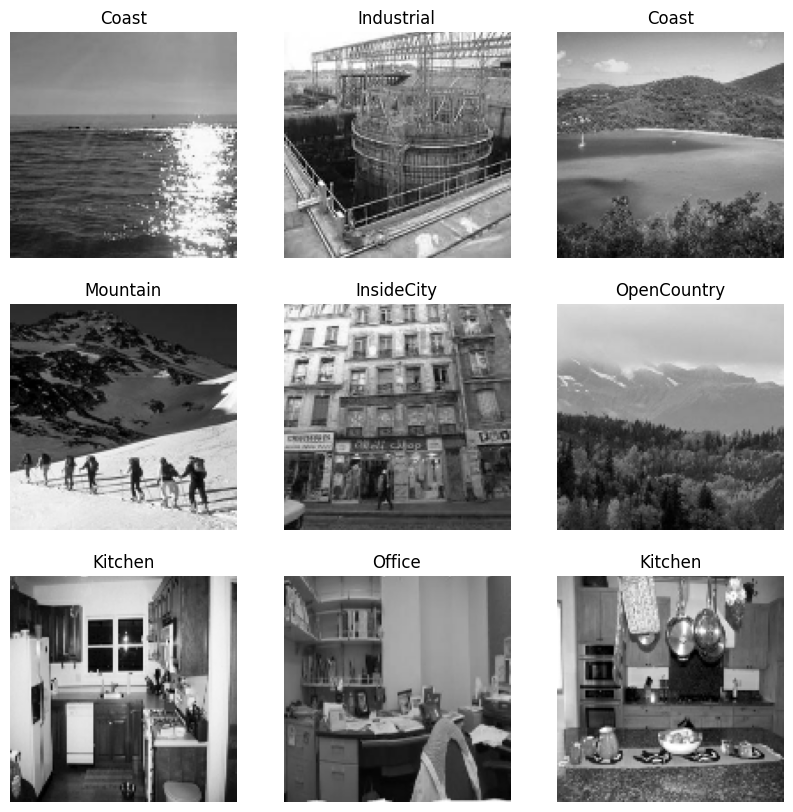

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Normalization layer
Create a normalization layer to scale inputs into a distribution centered around 0 with standard deviation 1
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization

In [ ]:
#Initialize the normalization layer
normalizer = layers.Normalization(axis=None)

#A Normalization layer should always either be adapted over a dataset or passed mean and variance.
#Adapt it to the training images
#Note: the dataset object contains both the images and the labels (we need to adapt it over the iamges only);
train_feature_ds = train_ds.map(lambda x, y:x)
normalizer.adapt(train_feature_ds)


### Data Augmentation
Create a TF sequential model for data augmentation that randomly flips the image horizontally

In [ ]:
rand_seed = 0
from keras.layers import RandomFlip

# Create a TF sequential model for data augmentation
data_augmentation = tf.keras.Sequential([
  RandomFlip('horizontal', seed=rand_seed)
])

## Create a Simple Net

![](simpleNet.jpeg)


### Simple Net


In [ ]:
def get_simple_aug_model(input_shape):
    """
    This function builds a Sequential model
    The model normalizes the input data and perform data augmentation.

    The function also compiles the model with the Adam optimiser, a cross
    entropy loss function, and a single accuracy metric.
    """

    # Define the input layer
    input_layer = tf.keras.layers.Input(shape=input_shape)

    # Data Augmentation Layer
    x = data_augmentation(input_layer)

    # Normalization Layer
    x = normalizer(input_layer)

    # First Convolutional Block
    x = Conv2D(filters=10, kernel_size=(5, 5), activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(3, 3))(x)

    # Second Convolutional Block
    x = Conv2D(filters=20, kernel_size=(5, 5), activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)

    # Flatten
    x = Flatten()(x)

    # Fully connected layers
    x = Dense(units=500, activation='relu')(x)
    x = Dense(units=100, activation='relu')(x)
    outputs = Dense(units=15, activation='softmax')(x)

    # Construct the Model
    model = tf.keras.models.Model(inputs=input_layer, outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
desired_input_shape = train_ds.element_spec[0].shape[1:]
aug_model = get_simple_aug_model(desired_input_shape)
aug_model.build(input_shape=(None,*desired_input_shape))

In [ ]:
#Print the model summary
aug_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 124, 124, 10)        │             760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 41, 41, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 37, 37, 20)          │           5,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 20)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 500)                 │       1,440,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          50,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │           1,515 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,497,895 (5.71 MB)

 Trainable params: 1,497,895 (5.71 MB)

 Non-trainable params: 0 (0.00 B)

### Define a function to evaluate a model's test accuracy

In [ ]:
def get_test_accuracy(model, test_ds):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))
    return test_acc

In [ ]:
# Calculate initial test accuracy (without any training)
test_aug = get_test_accuracy(aug_model, test_ds)

accuracy: 0.086


### Train the simple augmented model

In [ ]:
#callbacks = [checkpoint_every_epoch, checkpoint_best_only, early_stopping]
aug_history = aug_model.fit(train_ds, epochs=30, validation_data=test_ds) #, callbacks=callbacks


Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 0.0768 - loss: 24.9923 - val_accuracy: 0.1186 - val_loss: 2.6968
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.2648 - loss: 2.3589 - val_accuracy: 0.1759 - val_loss: 2.7419
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5778 - loss: 1.4602 - val_accuracy: 0.2154 - val_loss: 2.7923
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7754 - loss: 0.8536 - val_accuracy: 0.2214 - val_loss: 3.1389
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8874 - loss: 0.4694 - val_accuracy: 0.2134 - val_loss: 4.3412
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9151 - loss: 0.3413 - val_accuracy: 0.2429 - val_loss: 3.9445
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9616 - loss: 0.2011 - val_accuracy: 0.2590 - val_loss: 4.6354
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9833 - loss: 0.0737 - val_accuracy: 0.2509 

In [ ]:
#Test after fitting
test_aug = get_test_accuracy(aug_model, test_ds)

accuracy: 0.262


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
(2985,)
(2985,)


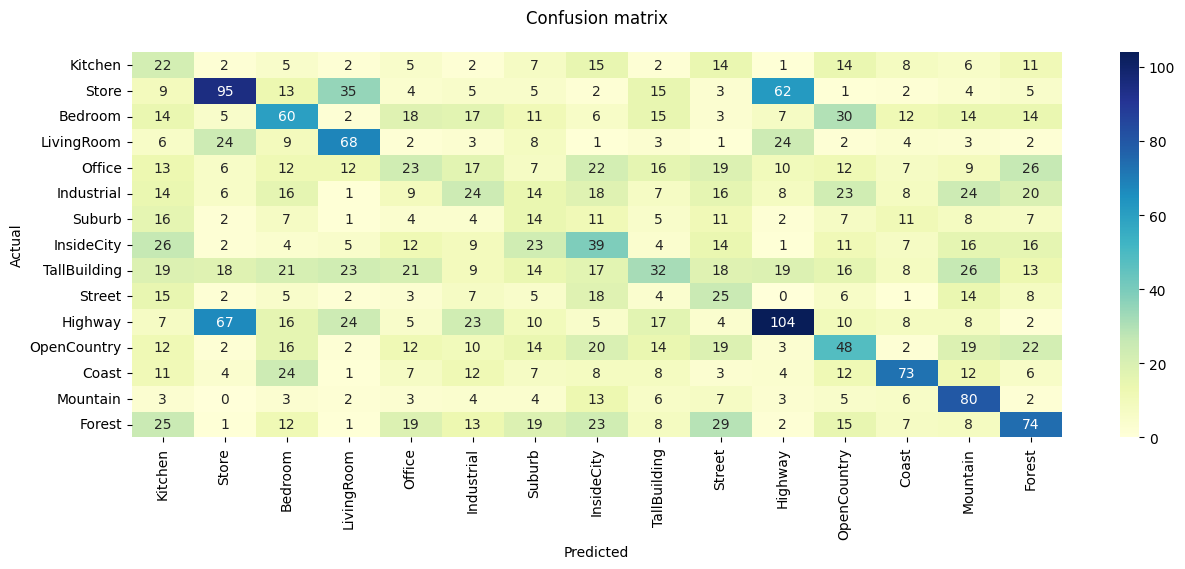

In [ ]:
#Since test set was shuffled, cache without shuffling. OTherwise the results will be erroneous.
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
cm = confMat(aug_model,test_ds)

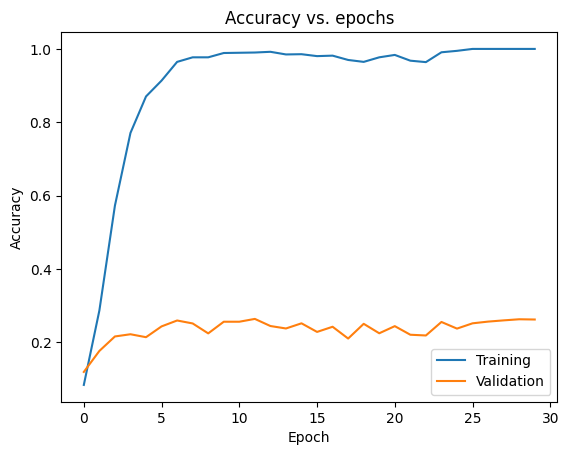

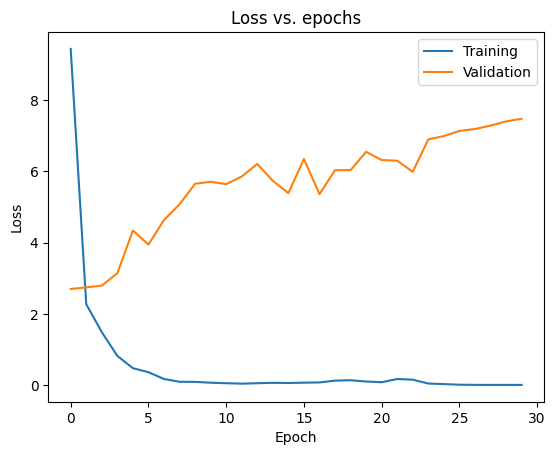

In [ ]:
#Run this cell to plot the new loss vs epoch graph
plotAccuracy(aug_history)
plotLoss(aug_history)


## Regularization


### Preventing overfitting

In [ ]:
def get_simple_regularized_model(input_shape, wd, rate):
    """
    This function updates the previous model by incorporating kernel regularization (weight decay) and
    Dropout layer and BatchNormalization layer.
    This model keeps the normalization and data augmentation layers as well.
    Function also compiles the model with the Adam optimiser, a cross
    entropy loss function, and a single accuracy metric.
    """

    # Define the input layer
    input_layer = Input(shape=input_shape)

    # Normalization Layer
    x = normalizer(input_layer)

    # Data Augmentation Layer
    x = data_augmentation(x)

    # First Convolutional Block with BatchNormalization and L2 Regularization
    x = Conv2D(10, (5, 5), padding='valid', kernel_regularizer=tf.keras.regularizers.l2(wd))(input_layer)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)

    # Second Convolutional Block with BatchNormalization and L2 Regularization
    x = Conv2D(20, (5, 5), padding='valid', kernel_regularizer=tf.keras.regularizers.l2(wd))(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)

    # Flatten the tensor
    x = Flatten()(x)

    # Fully connected layers with dropout
    x = Dense(500, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(wd))(x)
    x = Dropout(rate)(x)

    x = Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(wd))(x)
    x = Dropout(rate)(x)

    # Output layer
    output_layer = Dense(15, activation='softmax')(x)

    # Construct the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    # Compiling the model with Adam optimizer and cross entropy loss function
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
# Uses parameters provided to the function to control the weight decay and drop out rate
aug_reg_model = get_simple_regularized_model(desired_input_shape, 1e-3, 0.5)#1e-3, 0.5)

In [ ]:
aug_reg_history = aug_reg_model.fit(train_ds, epochs=30, validation_data=test_ds) #, callbacks=callbacks


Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 332ms/step - accuracy: 0.0710 - loss: 5.0809 - val_accuracy: 0.0878 - val_loss: 3.6627
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.0689 - loss: 3.6864 - val_accuracy: 0.0998 - val_loss: 3.5837
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1132 - loss: 3.5368 - val_accuracy: 0.0965 - val_loss: 3.4653
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1480 - loss: 3.4181 - val_accuracy: 0.1424 - val_loss: 3.3149
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1699 - loss: 3.2581 - val_accuracy: 0.1085 - val_loss: 3.3382
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1792 - loss: 3.1702 - val_accuracy: 0.0881 - val_loss: 3.4898
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1955 - loss: 3.0677 - val_accuracy: 0.1444 - val_loss: 3.1255
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2277 - loss: 2.9122 - val_accuracy: 0.1461 

In [ ]:
plotAccuracy(aug_reg_history)
plotLoss(aug_reg_history)

#### Changes in with respect to unregularized model.


In [ ]:
test_reg = get_test_accuracy(aug_reg_model, test_ds)

accuracy: 0.143


In [ ]:
# Plot confusion matrix for model.
cm = confMat(aug_reg_model,test_ds)

## Transfer Learning and Fine-tuning using Resnet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Input, layers
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Data Augmentation
from tensorflow.data import Dataset
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.layers import GaussianNoise, Dropout, RandomBrightness, RandomContrast
from tensorflow.keras.layers import RandomTranslation, RandomZoom, SpatialDropout2D

In [ ]:
def preprocess(images, labels):
  return preprocess_input(images), labels

Pre-processing the images so that it is ready to be input to the Resnet50 model

In [ ]:
train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

### Creating Model

In [ ]:
def get_TL_model(input_shape):
    """
    This function will create a model derived from Resnet50.
        It will include all but the last layer of Resnet50 (essentially the output will have a shape of (None, 2048)).

        Will add some new layers. How many of them depends on you!
        At the minimum, you will need the output layer corresponding to the new number of output categories.
        Explored how many additional layers to add, what regularization technique to apply, etc.

        Deciding how many layers of the Resnet50 will be frozen
        Initially, ensuring only the new layers added are trainable (i.e. all the layers of Resnet50 are frozen).

    Ensuring the input shape of the Resnet50 is set using the input_shape argument, given by the
    function argument.

    Function will also compile the model with the Adam optimiser,
    a sparse categorical cross entropy loss function, and a single accuracy metric.
    """

    # Load the ResNet50 model with pretrained ImageNet weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

    base_model.trainable = False
    # Make the last 70 layers trainable
    for layer in base_model.layers[:-70]:
        layer.trainable = True

    # Add global average pooling layer
    x = GlobalAveragePooling2D()(base_model.output)

    # Add a fully connected output layer with softmax activation
    predictions = Dense(15, activation='softmax')(x)

    # This is the model I will train
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with the Adam optimizer and a suitable loss function for sparse categorical labels
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
model_TL = get_TL_model(desired_input_shape)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.00001, patience=3, min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 5, mode = 'max', verbose = 1)
new_history = model_TL.fit(train_ds, epochs=50, validation_data=test_ds, callbacks=[early_stopping, reduce_lr])


Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 71s 639ms/step - accuracy: 0.4124 - loss: 2.0511 - val_accuracy: 0.2419 - val_loss: 4.1989 - learning_rate: 0.0010
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 196ms/step - accuracy: 0.8223 - loss: 0.6030 - val_accuracy: 0.4060 - val_loss: 2.7834 - learning_rate: 0.0010
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.9265 - loss: 0.2486 - val_accuracy: 0.5213 - val_loss: 2.0320 - learning_rate: 0.0010
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.9596 - loss: 0.1218 - val_accuracy: 0.5330 - val_loss: 1.9841 - learning_rate: 0.0010
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.9892 - loss: 0.0466 - val_accuracy: 0.7276 - val_loss: 1.0740 - learning_rate: 0.0010
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9922 - loss: 0.0388 - val_accuracy: 0.7494 - val_loss: 1.0355 - learning_rate: 0.0010
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 1.0000 - loss: 0.0066

In [ ]:
test_TL = get_test_accuracy(model_TL, test_ds)

accuracy: 0.832


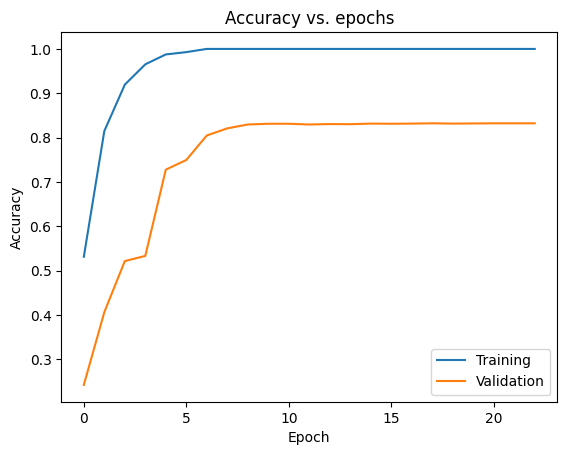

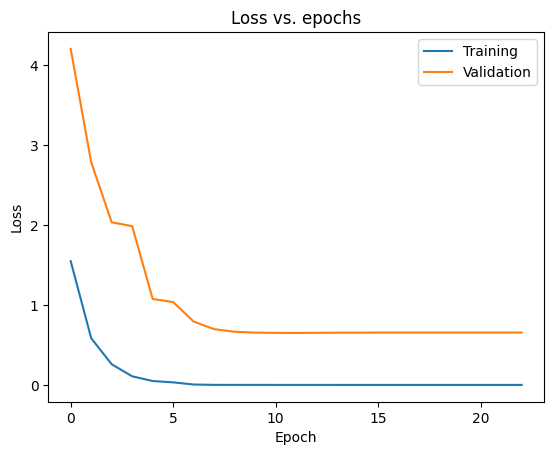

In [ ]:
#Run this cell to plot the new loss vs epoch graph
plotAccuracy(new_history)
plotLoss(new_history)

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step
(2985,)
(2985,)


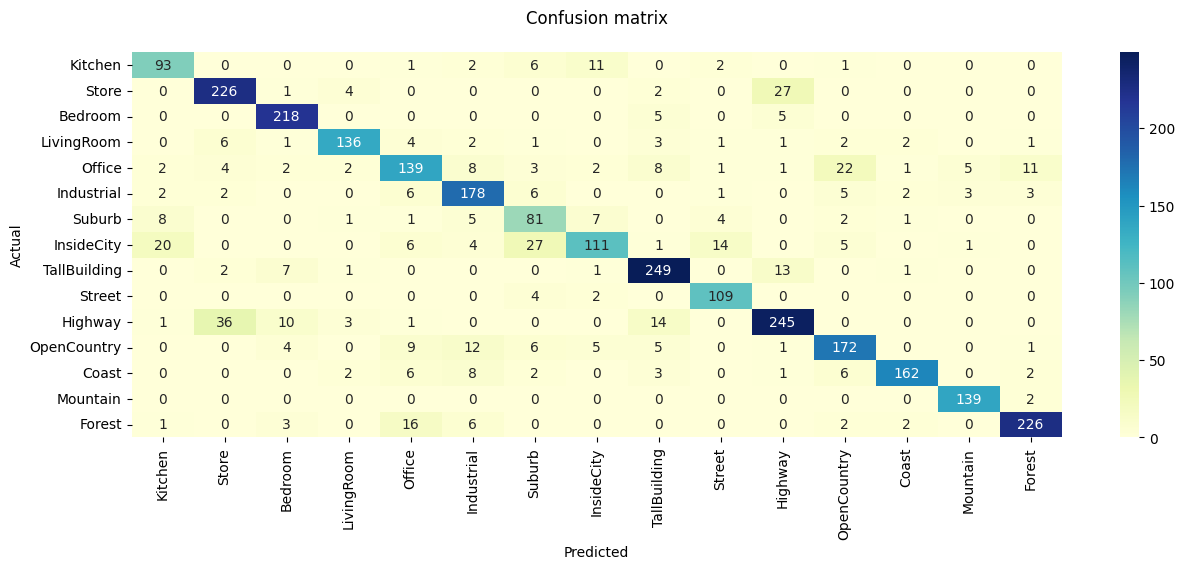

In [ ]:
cm = confMat(model_TL,test_ds)